In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv
/kaggle/input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl


# IMDB sentiment Classifier ~ 97% accuracy model - Harshal Gadhe

In [2]:
def make_df(path):
    df = pd.read_csv(path)
    df = pd.DataFrame(df)
    return df

In [3]:
df_imdb = make_df("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

In [4]:
df_imdb

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
df_imdb.nunique()

review       49582
sentiment        2
dtype: int64

In [6]:
df_imdb.isna().sum()

review       0
sentiment    0
dtype: int64

In [7]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


<Axes: xlabel='sentiment', ylabel='count'>

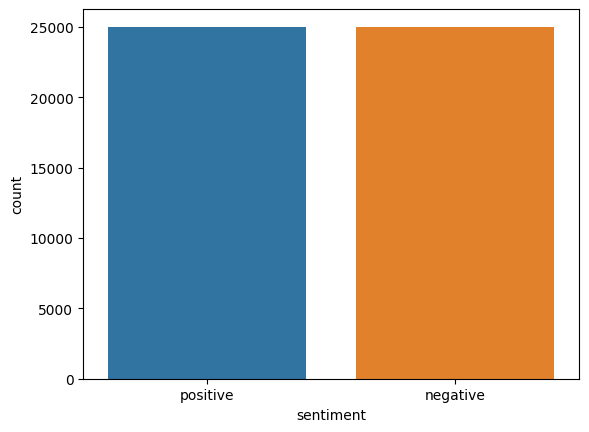

In [8]:
import seaborn as sns

sns.countplot(x = df_imdb['sentiment'])

### Data Visualization using word cloud.

In [9]:
from sklearn.preprocessing import LabelEncoder

sentences = df_imdb['review']
le = LabelEncoder()
df_imdb['sentiment'] = le.fit_transform(df_imdb['sentiment'])

(-0.5, 799.5, 799.5, -0.5)

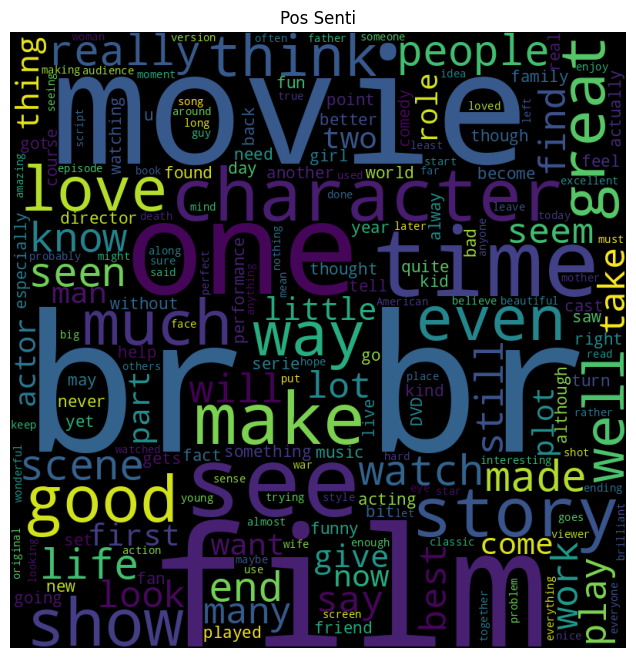

In [10]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# stopwords

stopwords = set(STOPWORDS)

pos=''.join(map(str, sentences[df_imdb['sentiment']==1]))
neg=''.join(map(str, sentences[df_imdb['sentiment']==0]))

wordcloud1 = WordCloud(width = 800, 
                        height = 800, 
                        background_color = 'black', 
                        stopwords = stopwords, 
                        min_font_size = 10).generate(pos)

plt.figure(figsize=(8,8))
plt.imshow(wordcloud1)
plt.title('Pos Senti')
plt.axis('off')

(-0.5, 799.5, 799.5, -0.5)

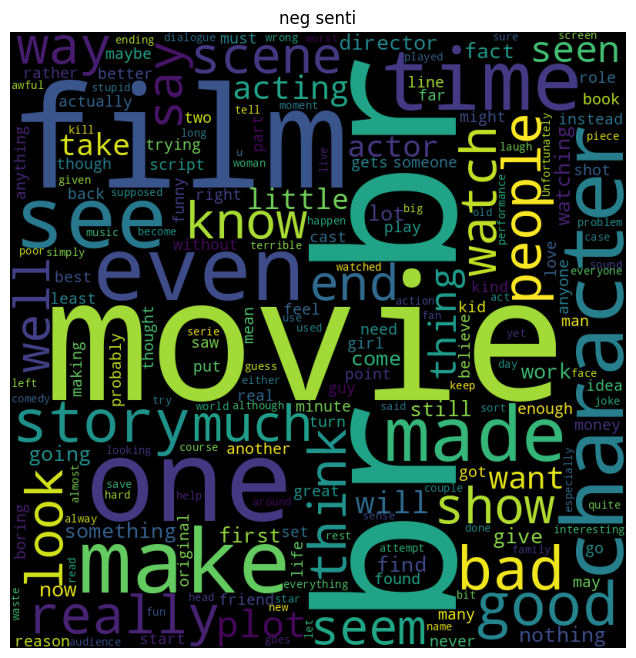

In [11]:
plt.figure(figsize=(8,8))
wordcloud2 = WordCloud(width=800,
                      height=800,
                      background_color='black',
                      stopwords=stopwords,
                      min_font_size=10).generate(neg)

plt.imshow(wordcloud2)
plt.title('neg senti')
plt.axis('off')


### There is a clear visual the 'br br' is used most times. Looking into the df_imdb, there are html inputs. This will affect sentiment analysis as it hold no sentimental value.

In [12]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
# splitting train-test

labels=to_categorical(df_imdb['sentiment'],num_classes=2)
X_train, X_test, Y_train, Y_test = train_test_split(df_imdb['review'],labels,test_size=0.1,random_state=42)

In [13]:
# cleaning data, utilizing glove embeddings. For the purpose of misspelling, concated words, or emojis.

glove_embeddings= np.load('/kaggle/input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl',
                          allow_pickle=True)


In [14]:
# build vocab and count each vocab using function below

def vocab_build(review):
    comments = review.apply(lambda s: s.split()).values
    vocab={}
    
    for comment in comments:
        for word in comment:
            try:
                vocab[word]+=1
            except KeyError:
                vocab[word]=1
    return vocab

In [15]:
# Embedding Coverage. Tells how much % of the words in data are covered by the vocabulary.
# sorted_oov is list of words that needs text cleaning.

def embedding_coverage(review, embeddings):
    
    vocab=vocab_build(review)
    
    covered={}
    word_count={}
    oov={}
    covered_num=0
    oov_num=0
    
    for word in vocab:
        try:
            covered[word]=embeddings[word]
            covered_num+=vocab[word]
            word_count[word]=vocab[word]
        except:
            oov[word]=vocab[word]
            oov_num+=oov[word]
            
    vocab_coverage=len(covered)/len(vocab)*100
    text_coverage=covered_num/(covered_num+oov_num)*100
    
    sorted_oov=sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    sorted_word_count=sorted(word_count.items(), key=operator.itemgetter(1))[::-1]
    
    return sorted_word_count, sorted_oov, vocab_coverage, text_coverage

In [16]:
import operator

train_covered, train_oov, train_vocab_coverage, train_text_coverage = embedding_coverage(X_train, glove_embeddings)

test_covered, test_oov, test_vocab_coverage, test_text_coverage = embedding_coverage(X_test, glove_embeddings)

print(f'GloVe embeddings cover {round(train_vocab_coverage, 2)}% of vocabulary and {round(train_text_coverage, 2)}% text in training set')
print(f'GloVe embeddings cover {round(test_vocab_coverage, 2)}% of vocabulary and {round(test_text_coverage, 2)}% text in test set')

GloVe embeddings cover 26.79% of vocabulary and 87.64% text in training set
GloVe embeddings cover 42.28% of vocabulary and 87.54% text in test set


In [17]:
# train_oov shows the words that needs preprocessing

train_oov[:10]

[('/><br', 90911),
 ('/>The', 12905),
 ('film,', 7284),
 ('movie,', 7143),
 ('/>I', 6649),
 ("isn't", 5253),
 ('"The', 4370),
 ('/>This', 3918),
 ("he's", 3914),
 ("wasn't", 3796)]

In [18]:
# cleaning sentences.
# this part consist of specific fixes.

import re

def clean_sentences(line):
    
    line=re.sub('<.*?>','',line) # removing html tags
    
    #removing contractions
    line=re.sub("isn't",'is not',line)
    line=re.sub("he's",'he is',line)
    line=re.sub("wasn't",'was not',line)
    line=re.sub("there's",'there is',line)
    line=re.sub("couldn't",'could not',line)
    line=re.sub("won't",'will not',line)
    line=re.sub("they're",'they are',line)
    line=re.sub("she's",'she is',line)
    line=re.sub("There's",'there is',line)
    line=re.sub("wouldn't",'would not',line)
    line=re.sub("haven't",'have not',line)
    line=re.sub("That's",'That is',line)
    line=re.sub("you've",'you have',line)
    line=re.sub("He's",'He is',line)
    line=re.sub("what's",'what is',line)
    line=re.sub("weren't",'were not',line)
    line=re.sub("we're",'we are',line)
    line=re.sub("hasn't",'has not',line)
    line=re.sub("you'd",'you would',line)
    line=re.sub("shouldn't",'should not',line)
    line=re.sub("let's",'let us',line)
    line=re.sub("they've",'they have',line)
    line=re.sub("You'll",'You will',line)
    line=re.sub("i'm",'i am',line)
    line=re.sub("we've",'we have',line)
    line=re.sub("it's",'it is',line)
    line=re.sub("don't",'do not',line)
    line=re.sub("that´s",'that is',line)
    line=re.sub("I´m",'I am',line)
    line=re.sub("it’s",'it is',line)
    line=re.sub("she´s",'she is',line)
    line=re.sub("he’s'",'he is',line)
    line=re.sub('I’m','I am',line)
    line=re.sub('I’d','I did',line)
    line=re.sub("he’s'",'he is',line)
    line=re.sub('there’s','there is',line)
    
    #special characters and emojis
    line=re.sub('\x91The','The',line)
    line=re.sub('\x97','',line)
    line=re.sub('\x84The','The',line)
    line=re.sub('\uf0b7','',line)
    line=re.sub('¡¨','',line)
    line=re.sub('\x95','',line)
    line=re.sub('\x8ei\x9eek','',line)
    line=re.sub('\xad','',line)
    line=re.sub('\x84bubble','bubble',line)
    
    # remove concated words
    line=re.sub('trivialBoring','trivial Boring',line)
    line=re.sub('Justforkix','Just for kix',line)
    line=re.sub('Nightbeast','Night beast',line)
    line=re.sub('DEATHTRAP','Death Trap',line)
    line=re.sub('CitizenX','Citizen X',line)
    line=re.sub('10Rated','10 Rated',line)
    line=re.sub('_The','_ The',line)
    line=re.sub('1Sound','1 Sound',line)
    line=re.sub('blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah','blah blah',line)
    line=re.sub('ResidentHazard','Resident Hazard',line)
    line=re.sub('iameracing','i am racing',line)
    line=re.sub('BLACKSNAKE','Black Snake',line)
    line=re.sub('DEATHSTALKER','Death Stalker',line)
    line=re.sub('_is_','is',line)
    line=re.sub('10Fans','10 Fans',line)
    line=re.sub('Yellowcoat','Yellow coat',line)
    line=re.sub('Spiderbabe','Spider babe',line)
    line=re.sub('Frightworld','Fright world',line)
    
    #removing punctuations
    
    punctuations = '@#!~?+&*[]-%._-:/£();$=><|{}^' + '''"“´”'`'''
    for p in punctuations:
        line = line.replace(p, f' {p} ')
        
    line=re.sub(',',' , ',line)
        
    # ... and ..
    line = line.replace('...', ' ... ')
    
    if '...' not in line:
        line = line.replace('..', ' ... ')
        
    return line

In [19]:
X_train=X_train.apply(lambda s: clean_sentences(s))
X_test=X_test.apply(lambda s: clean_sentences(s))

train_covered,train_oov,train_vocab_coverage,train_text_coverage=embedding_coverage(X_train,glove_embeddings)
print(f"Glove embeddings cover {round(train_vocab_coverage,2)}% of vocabulary and {round(train_text_coverage,2)}% text in training set")

test_covered,test_oov,test_vocab_coverage,test_text_coverage=embedding_coverage(X_test,glove_embeddings)
print(f"Glove embeddings cover {round(test_vocab_coverage,2)}% of vocabulary and {round(test_text_coverage,2)}% text in training set")

Glove embeddings cover 86.87% of vocabulary and 99.82% text in training set
Glove embeddings cover 95.73% of vocabulary and 99.83% text in training set


Shown above output, vocabulary % have drastically improved.

In [22]:
# Using sns to count 10 most used words in training and testing

punctuations = '@#!~?+&*[]-%._-:/£();$=><|{},^' + '''"“´”'`'''
train_word=[]
train_count=[]

i=1
for word, count in train_covered:
    if word not in punctuations:
        train_word.append(word)
        train_count.append(count)
        i+=1
    if(i==15):
        break

In [23]:
test_word=[]
test_count=[]

i=1
for word, count in test_covered:
    if word not in punctuations:
        test_word.append(word)
        test_count.append(count)
        i+=1
    if(i==15):
        break

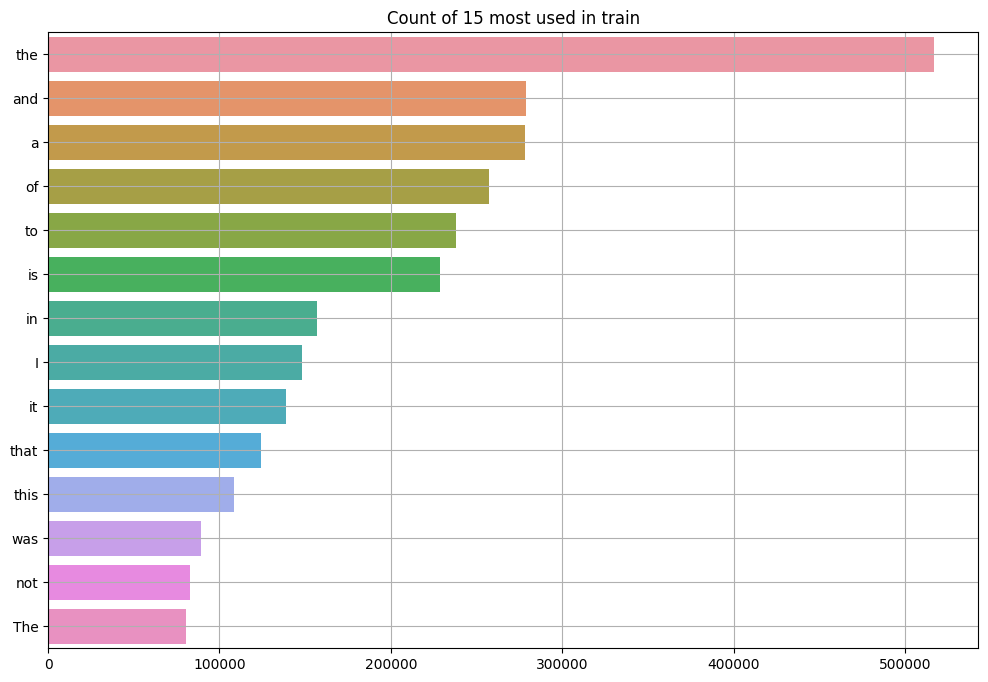

In [25]:
plt.figure(figsize=(12,8))
sns.barplot(x=train_count,y=train_word).set_title('Count of 15 most used in train')
plt.grid()

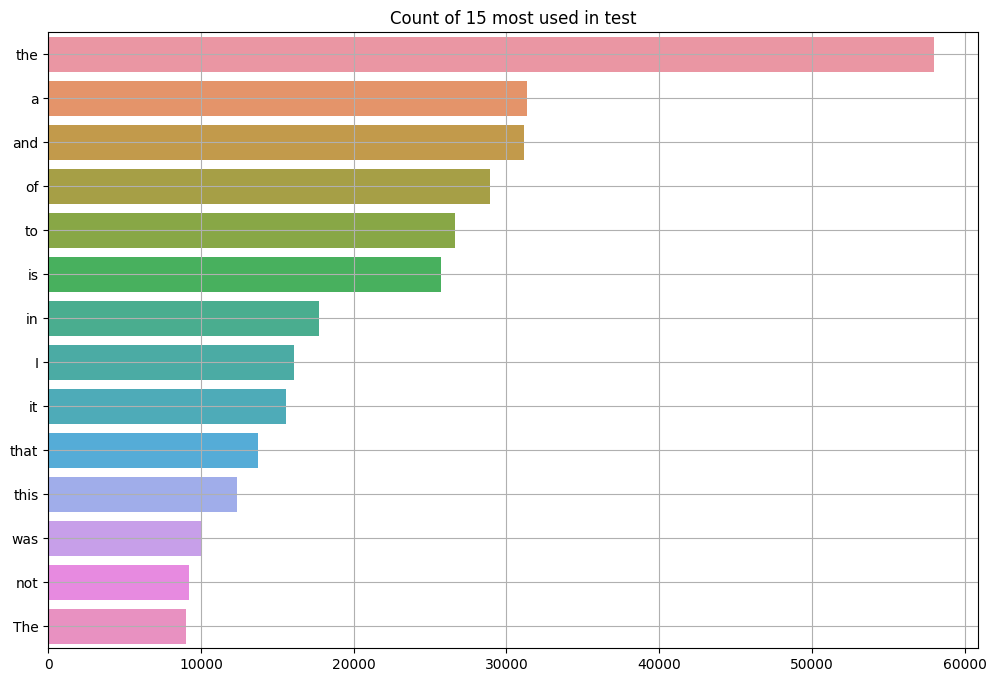

In [26]:
plt.figure(figsize=(12,8))
sns.barplot(x=test_count,y=test_word).set_title('Count of 15 most used in test')
plt.grid()

## Preprocessing summary

- NaN value check
- sentiment value count
- wordcloud
- GloVe embeddings + embedding coverage
- Sentence cleaning (too specific example, inefficient)
- Punctuation spacing
- Barplot for most frequent words

# Sentiment Analysis - Cleaning,EDA & BERT(88% Acc) - Madhav Mathur

Install
* Numpy
* Pandas
* Matplotlib
* Fastai


In [30]:
def make_df(url):
    csv = pd.read_csv(url)
    df = pd.DataFrame(csv)
    return df

In [31]:
df_imdb = make_df('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [32]:
df_imdb.head(10)

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses main...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his ...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've ...",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with so...",negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler's play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of conta...",positive
5,"Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it's not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like ""dressed-up midgets"" than children, but that only makes them more fun to watch. And the mother's slow awakening to what's happening in the world and under her own roof is believable and startling....",positive
6,I sure would like to see a resurrection of a up dated Seahunt series with the tech they have today it would bring back the kid excitement in me.I grew up on black and white TV and Seahunt with Gunsmoke were my hero's every week.You have my vote for a comeback of a new sea hunt.We need a change o

In [33]:
df_imdb.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,"Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stimulating and captivating, always keeping the viewer peeking around the corner to see what was coming up next. She is as down to earth and as personable as you get, like one of us which made the show all the more enjoyable. Special guests, who are friends as well made for a nice surprise too. Loved the 'first' theme and that the audience was invited to play along too. I must admit I was shocked to see her come in under her time limits on a few things, but she did it and by golly I'll be ...",positive
freq,5,25000


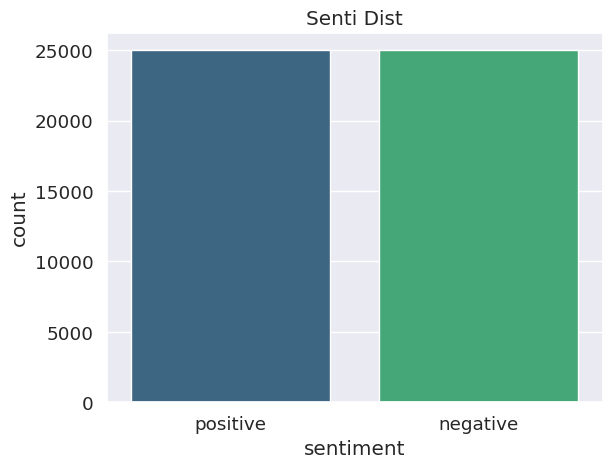

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style = 'darkgrid', font_scale = 1.2)
sns.countplot(data = df_imdb, x='sentiment', palette='viridis')
plt.title('Senti Dist')
plt.show()

In [37]:
df_imdb.isna().sum()

review       0
sentiment    0
dtype: int64

In [39]:
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

### Basic Data Cleaning

In [40]:
import re

def strip_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

#squre brackets
def remov_btwn_sqbrkts(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL
def remov_url(text):
    return re.sub(r'http\S+', '', text)

# Removing the stopwords from txt
def remov_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
            
    return " ".join(tinal_text)


# understand code above